In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
%%time

filter_string = ' & '.join(
    (
        '(1 <= PULocationID) & (PULocationID <= 263)',
        '(1 <= DOLocationID) & (DOLocationID <= 263)'
    )
)

pre_covid_data = pd.read_parquet(
    path='2019',
    columns=['PULocationID', 'DOLocationID']
)

covid_data = pd.read_parquet(
    path='2020',
    columns=['PULocationID', 'DOLocationID']
)

pre_covid_data = pre_covid_data.query(filter_string)
covid_data = covid_data.query(filter_string)

pre_covid_data = pre_covid_data.sample(n=len(covid_data))

CPU times: total: 18.7 s
Wall time: 25.1 s


### Földrajzi adatok beolvasása

In [3]:
data = (
    gpd
    .read_file(
        filename='taxi_zones/taxi_zones.shp',
        ignore_fields=['Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough']
    )
    .set_index('OBJECTID')
    .rename_axis('LocationID')
)

### Körzetadatok összegzése

In [4]:
pickup_pre_covid = (
    pre_covid_data
    .PULocationID
    .value_counts()
    .reindex_like(data)
)

dropoff_pre_covid = (
    pre_covid_data
    .DOLocationID
    .value_counts()
    .reindex_like(data)
)

pickup_covid = (
    covid_data
    .PULocationID
    .value_counts()
    .reindex_like(data)
)

dropoff_covid = (
    covid_data
    .DOLocationID
    .value_counts()
    .reindex_like(data)
)

### Logaritmus vétel és hiányzó adatok kitöltése

In [5]:
data['PUFrequencyPrC'] = np.log(pickup_pre_covid).fillna(value=0)
data['DOFrequencyPrC'] = np.log(dropoff_pre_covid).fillna(value=0)

data['PUFrequencyC'] = np.log(pickup_covid).fillna(value=0)
data['DOFrequencyC'] = np.log(dropoff_covid).fillna(value=0)

### Kirajzolás

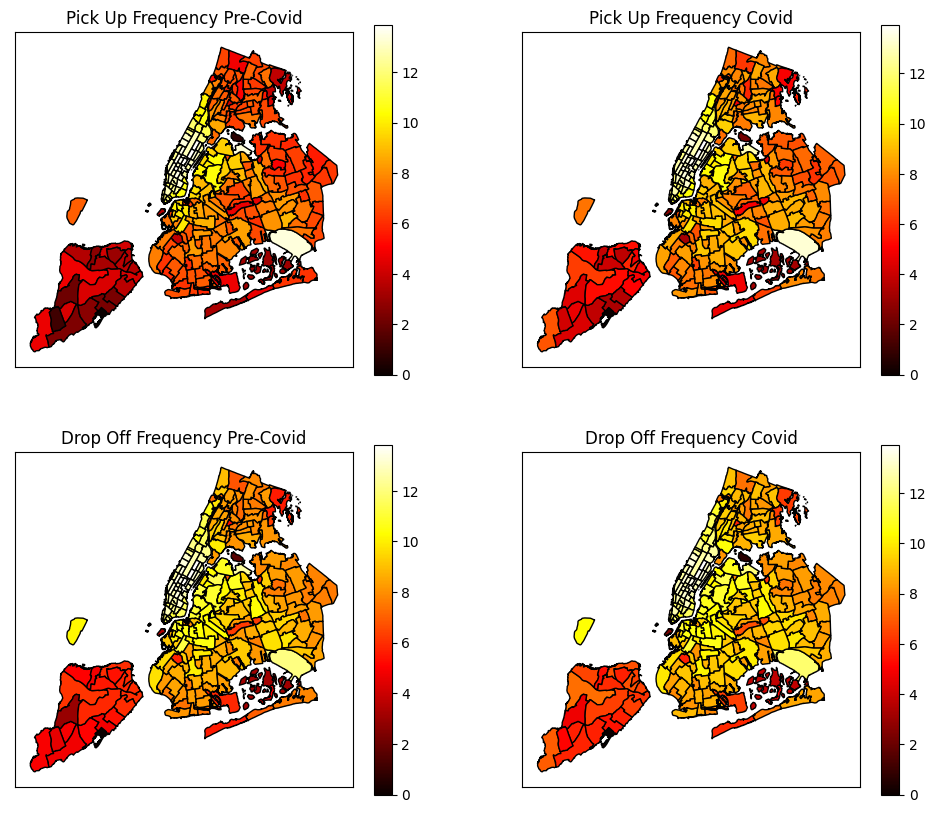

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

ax[1][0].set_xticks([])
ax[1][0].set_yticks([])

ax[1][1].set_xticks([])
ax[1][1].set_yticks([])

ax[0][0].title.set_text('Pick Up Frequency Pre-Covid')
ax[0][1].title.set_text('Pick Up Frequency Covid')

ax[1][0].title.set_text('Drop Off Frequency Pre-Covid')
ax[1][1].title.set_text('Drop Off Frequency Covid')

data.plot(
    cmap='hot',
    legend=True,
    column='PUFrequencyPrC',
    ax=ax[0][0],
    edgecolor='black'
)

data.plot(
    cmap='hot',
    legend=True,
    column='PUFrequencyC',
    ax=ax[0][1],
    edgecolor='black'
)

data.plot(
    cmap='hot',
    legend=True,
    column='DOFrequencyPrC',
    ax=ax[1][0],
    edgecolor='black'
)

data.plot(
    cmap='hot',
    legend=True,
    column='DOFrequencyC',
    ax=ax[1][1],
    edgecolor='black'
)

plt.show()